In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torchtext==0.6.0

import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.optim as optim

from torchtext import data

from torchtext.data import Example, Dataset, Field

from transformers import AutoTokenizer, AutoModel

import functools

import spacy
import numpy as np
import pandas as pd

import time
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 734.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.0 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [4]:

tokenizer = AutoTokenizer.from_pretrained('dbmdz/bert-base-italian-xxl-uncased')

init_token = tokenizer.cls_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, pad_token, unk_token)

init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, pad_token_idx, unk_token_idx)

max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

print(max_input_length)

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/243k [00:00<?, ?B/s]

[CLS] [PAD] [UNK]
102 0 101
512


In [5]:
def cut_and_convert_to_id(tokens, tokenizer, max_input_length):
    tokens = tokens[:max_input_length-1]
    tokens = tokenizer.convert_tokens_to_ids(tokens)
    return tokens
def cut_to_max_length(tokens, max_input_length):
    tokens = tokens[:max_input_length-1]
    return tokens

text_preprocessor = functools.partial(cut_and_convert_to_id,
                                      tokenizer = tokenizer,
                                      max_input_length = max_input_length)

tag_preprocessor = functools.partial(cut_to_max_length,
                                     max_input_length = max_input_length)


In [6]:
# Cella 1 - Definizione dei campi e costruzione dei dataset

# Definizione dei campi
TEXT = data.Field(use_vocab = False,
                  lower=True,
                  preprocessing = text_preprocessor,
                  init_token = init_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

UD_TAGS = data.Field(unk_token = None,
                     init_token = '<pad>',
                     preprocessing = tag_preprocessor)

# Funzione per la lettura dei dati da un file
def read_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        sentence = []
        for line in file:
            if line.strip() == '':
                if sentence:
                    data.append(sentence)
                    sentence = []
            else:
                parts = line.split()
                text = parts[0]
                tag = parts[1]
                sentence.append((text, tag))
    return data

# Percorsi dei file per train, validation e test
train_path = '/content/drive/MyDrive/Colab Notebooks/trainU.txt'
valid_path = '/content/drive/MyDrive/Colab Notebooks/validU.txt'
test_path = '/content/drive/MyDrive/Colab Notebooks/testU.txt'


# Leggi i dati da tutti i file
train_data = read_data(train_path)
valid_data = read_data(valid_path)
test_data = read_data(test_path)

# Creazione degli oggetti Example per ogni set di dati
def create_examples(data):
    examples = []
    for sentence in data:
        words, tags = zip(*sentence)
        example = Example.fromlist([list(words), list(tags)], [('text', TEXT), ('udtags', UD_TAGS)])
        examples.append(example)
    return examples

# Creazione dei Dataset utilizzando gli Example
train_examples = create_examples(train_data)
valid_examples = create_examples(valid_data)
test_examples = create_examples(test_data)

train_data = Dataset(train_examples, [('text', TEXT), ('udtags', UD_TAGS)])
valid_data = Dataset(valid_examples, [('text', TEXT), ('udtags', UD_TAGS)])
test_data = Dataset(test_examples, [('text', TEXT), ('udtags', UD_TAGS)])

UD_TAGS.build_vocab(train_data)

print(UD_TAGS.vocab.stoi)



defaultdict(None, {'<pad>': 0, 'NOUN': 1, 'DET': 2, 'ADP': 3, 'PUNCT': 4, 'VERB': 5, 'ADJ': 6, 'PROPN': 7, 'AUX': 8, 'ADV': 9, 'PRON': 10, 'CCONJ': 11, 'NUM': 12, 'SCONJ': 13, 'X': 14, 'SYM': 15, 'INTJ': 16, 'PART': 17})


In [9]:
print(vars(train_data.examples[0]))

UD_TAGS.build_vocab(train_data)

print(UD_TAGS.vocab.stoi)

{'text': [4139, 687], 'udtags': ['PROPN', 'PUNCT']}
defaultdict(None, {'<pad>': 0, 'NOUN': 1, 'DET': 2, 'ADP': 3, 'PUNCT': 4, 'VERB': 5, 'ADJ': 6, 'PROPN': 7, 'AUX': 8, 'ADV': 9, 'PRON': 10, 'CCONJ': 11, 'NUM': 12, 'SCONJ': 13, 'X': 14, 'SYM': 15, 'INTJ': 16, 'PART': 17})


In [10]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=lambda x: len(x.text))

In [11]:
class BERTPoSTagger(nn.Module):
    def __init__(self,
                 bert,
                 output_dim,
                 dropout):

        super().__init__()

        self.bert = bert

        embedding_dim = bert.config.to_dict()['hidden_size']

        self.fc = nn.Linear(embedding_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        #text = [sent len, batch size]

        text = text.permute(1, 0)

        #text = [batch size, sent len]

        embedded = self.dropout(self.bert(text)[0])

        #embedded = [batch size, seq len, emb dim]

        embedded = embedded.permute(1, 0, 2)

        #embedded = [sent len, batch size, emb dim]

        predictions = self.fc(self.dropout(embedded))

        #predictions = [sent len, batch size, output dim]

        return predictions




In [12]:
bert = AutoModel.from_pretrained('dbmdz/bert-base-italian-xxl-uncased')



OUTPUT_DIM = len(UD_TAGS.vocab)
DROPOUT = 0.25

model = BERTPoSTagger(bert,
                      OUTPUT_DIM,
                      DROPOUT)


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [13]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 110,709,522 trainable parameters


In [14]:
LEARNING_RATE = 5e-5

optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)



TAG_PAD_IDX = UD_TAGS.vocab.stoi[UD_TAGS.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)


In [15]:
model = model.to(device)
criterion = criterion.to(device)

In [16]:

def categorical_accuracy(preds, y, tag_pad_idx):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]]).to(device)

In [17]:
def train(model, iterator, optimizer, criterion, tag_pad_idx):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        text = batch.text
        tags = batch.udtags

        optimizer.zero_grad()

        #text = [sent len, batch size]

        predictions = model(text)

        #predictions = [sent len, batch size, output dim]
        #tags = [sent len, batch size]

        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)

        #predictions = [sent len * batch size, output dim]
        #tags = [sent len * batch size]

        loss = criterion(predictions, tags)

        acc = categorical_accuracy(predictions, tags, tag_pad_idx)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import torch

def evaluate(model, iterator, criterion, tag_pad_idx, UD_TAGS):
    epoch_loss = 0
    epoch_acc = 0

    tag_errors = defaultdict(int)
    tag_totals = defaultdict(int)

    all_predictions = []
    all_tags = []

    model.eval()

    with torch.no_grad():
        for batch in iterator:
            text = batch.text
            tags = batch.udtags

            predictions = model(text)
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)

            loss = criterion(predictions, tags)
            acc = categorical_accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            top_predictions = predictions.argmax(-1)
            for pred_tag, true_tag in zip(top_predictions.cpu().numpy(), tags.cpu().numpy()):
                tag_totals[UD_TAGS.vocab.itos[true_tag]] += 1
                if pred_tag != true_tag:
                    tag_errors[UD_TAGS.vocab.itos[true_tag]] += 1

            all_predictions.extend(top_predictions.cpu().numpy())
            all_tags.extend(tags.cpu().numpy())

    avg_loss = epoch_loss / len(iterator)
    avg_acc = epoch_acc / len(iterator)

    tag_error_percentages = {
        tag: (tag_errors[tag] / tag_totals[tag]) * 100 if tag_totals[tag] != 0 else 0
        for tag in tag_totals
    }

    sorted_tag_errors = sorted(tag_error_percentages.items(), key=lambda x: x[1], reverse=True)

    confusion_mat = confusion_matrix(all_tags, all_predictions, labels=[tag_idx for tag_idx in range(len(UD_TAGS.vocab.itos)) if UD_TAGS.vocab.itos[tag_idx] != '<pad>'])

    precision = precision_score(all_tags, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_tags, all_predictions, average='weighted', zero_division=0)

    return avg_loss, avg_acc, sorted_tag_errors, all_tags, all_predictions, confusion_mat, precision, recall


In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10  # Numero di epoch da eseguire
best_valid_loss = float('inf')  # Inizializzazione della migliore perdita su dati di validazione

for epoch in range(N_EPOCHS):  # Ciclo attraverso gli epoch definiti

    start_time = time.time()  # Registra il tempo di inizio dell'epoch

    # Addestramento del modello sul dataset di addestramento
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, TAG_PAD_IDX)

    # Valutazione del modello sul dataset di validazione
    valid_loss, valid_acc, tag_errors, all_tags, all_predictions, conf_matrix, precision, recall = evaluate(model, valid_iterator, criterion, TAG_PAD_IDX, UD_TAGS)

    end_time = time.time()  # Registra il tempo di fine dell'epoch

    # Calcola la durata dell'epoch
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Aggiorna i pesi del modello se la perdita sul dataset di validazione è migliorata
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/bert.pt')  # Salva i pesi del modello

    # Stampa le informazioni sull'epoch corrente (perdita e accuratezza di addestramento e validazione)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')



We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch: 01 | Epoch Time: 2m 43s
	Train Loss: 0.267 | Train Acc: 92.46%
	 Val. Loss: 0.156 |  Val. Acc: 95.45%
Epoch: 02 | Epoch Time: 2m 40s
	Train Loss: 0.092 | Train Acc: 97.32%
	 Val. Loss: 0.122 |  Val. Acc: 96.48%
Epoch: 03 | Epoch Time: 2m 41s
	Train Loss: 0.060 | Train Acc: 98.18%
	 Val. Loss: 0.125 |  Val. Acc: 96.79%
Epoch: 04 | Epoch Time: 2m 42s
	Train Loss: 0.040 | Train Acc: 98.80%
	 Val. Loss: 0.139 |  Val. Acc: 96.56%
Epoch: 05 | Epoch Time: 2m 42s
	Train Loss: 0.029 | Train Acc: 99.12%
	 Val. Loss: 0.143 |  Val. Acc: 96.66%
Epoch: 06 | Epoch Time: 2m 42s
	Train Loss: 0.022 | Train Acc: 99.33%
	 Val. Loss: 0.153 |  Val. Acc: 96.58%
Epoch: 07 | Epoch Time: 2m 41s
	Train Loss: 0.019 | Train Acc: 99.45%
	 Val. Loss: 0.151 |  Val. Acc: 96.65%
Epoch: 08 | Epoch Time: 2m 41s
	Train Loss: 0.015 | Train Acc: 99.54%
	 Val. Loss: 0.167 |  Val. Acc: 96.61%
Epoch: 09 | Epoch Time: 2m 42s
	Train Loss: 0.013 | Train Acc: 99.58%
	 Val. Loss: 0.168 |  Val. Acc: 96.52%
Epoch: 10 | Epoch T

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tag: NOUN | Precision: 95.68% | Recall: 96.28%
Tag: DET | Precision: 98.22% | Recall: 99.71%
Tag: ADP | Precision: 99.39% | Recall: 99.21%
Tag: PUNCT | Precision: 99.75% | Recall: 99.91%
Tag: VERB | Precision: 96.39% | Recall: 95.83%
Tag: ADJ | Precision: 86.94% | Recall: 93.97%
Tag: PROPN | Precision: 92.47% | Recall: 80.20%
Tag: AUX | Precision: 97.27% | Recall: 96.79%
Tag: ADV | Precision: 96.12% | Recall: 92.77%
Tag: PRON | Precision: 98.54% | Recall: 98.78%
Tag: CCONJ | Precision: 98.87% | Recall: 99.62%
Tag: NUM | Precision: 97.58% | Recall: 94.15%
Tag: SCONJ | Precision: 90.65% | Recall: 97.00%
Tag: X | Precision: 75.00% | Recall: 23.08%
Tag: SYM | Precision: 100.00% | Recall: 100.00%
Tag: INTJ | Precision: 0.00% | Recall: 0.00%
Tag: PART | Precision: 0.00% | Recall: 0.00%
Tag: NOUN | F1 Score: 95.98%
Tag: DET | F1 Score: 98.96%
Tag: ADP | F1 Score: 99.30%
Tag: PUNCT | F1 Score: 99.83%
Tag: VERB | F1 Score: 96.11%
Tag: ADJ | F1 Score: 90.32%
Tag: PROPN | F1 Score: 85.90%
Tag: AU

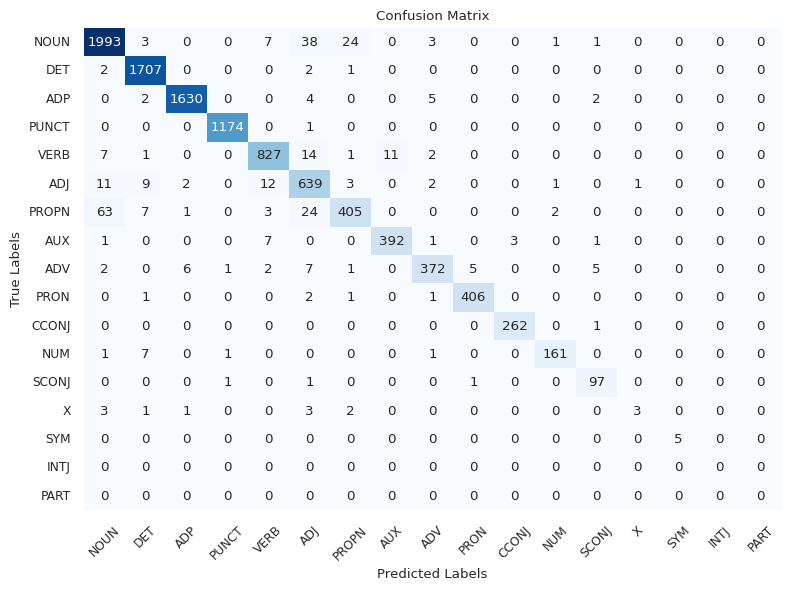

In [ ]:
# Cella 24 - Valutazione del modello sul test set

import matplotlib.pyplot as plt
import seaborn as sns

# Carica i pesi salvati del modello dal file 'bilstm-model.pt'
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/bert.pt'))

# Valuta le prestazioni del modello sul dataset di test
test_loss, test_acc, tag_errors, all_tags, all_predictions, conf_matrix, precision, recall = evaluate(model, test_iterator, criterion, TAG_PAD_IDX, UD_TAGS)

# Calcola la matrice di confusione utilizzando sklearn
conf_matrix = confusion_matrix(all_tags, all_predictions, labels=[tag_idx for tag_idx in range(len(UD_TAGS.vocab.itos)) if UD_TAGS.vocab.itos[tag_idx] != '<pad>'])

# Rimuovi le predizioni relative al tag '<pad>' da all_tags e all_predictions
all_tags_filtered = [tag for tag in all_tags if UD_TAGS.vocab.itos[tag] != '<pad>']
all_predictions_filtered = [pred for idx, pred in enumerate(all_predictions) if UD_TAGS.vocab.itos[all_tags[idx]] != '<pad>']

# Calcolo della precisione, del richiamo e dell'accuratezza per ogni classe
precisions = precision_score(all_tags_filtered, all_predictions_filtered, average=None, labels=[tag_idx for tag_idx in range(len(UD_TAGS.vocab.itos)) if UD_TAGS.vocab.itos[tag_idx] != '<pad>'])
recalls = recall_score(all_tags_filtered, all_predictions_filtered, average=None, labels=[tag_idx for tag_idx in range(len(UD_TAGS.vocab.itos)) if UD_TAGS.vocab.itos[tag_idx] != '<pad>'])

# Stampa della precisione, del richiamo e dell'accuratezza per ogni classe
for tag, precision, recall in zip([tag for tag in UD_TAGS.vocab.itos if tag != '<pad>'], precisions, recalls):
    print(f'Tag: {tag} | Precision: {precision*100:.2f}% | Recall: {recall*100:.2f}%')

# Calcolo della F1 score per ogni classe
f1_scores = []
for precision, recall in zip(precisions, recalls):
    if precision == 0 and recall == 0:
        f1_scores.append(0)  # Se sia la precisione che il richiamo sono nulli, la F1 sarà 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)

# Stampare i valori F1 in percentuale per ogni classe
for tag, f1_score in zip([tag for tag in UD_TAGS.vocab.itos if tag != '<pad>'], f1_scores):
    f1_percent = f1_score * 100
    print(f'Tag: {tag} | F1 Score: {f1_percent:.2f}%')



# Calcolo dell'accuratezza per ogni classe
class_accuracy = {}
for tag_idx in range(len(UD_TAGS.vocab.itos)):
    tag = UD_TAGS.vocab.itos[tag_idx]
    if tag != '<pad>':
        correct_indices = [i for i, (true, pred) in enumerate(zip(all_tags, all_predictions)) if true == tag_idx and pred == true]
        total_instances = len([true for true in all_tags if true == tag_idx])
        class_acc = len(correct_indices) / total_instances if total_instances != 0 else 0
        class_accuracy[tag] = class_acc

# Stampa dell'accuratezza per ogni classe
for tag, acc in class_accuracy.items():
    print(f'Tag: {tag} | Accuracy: {acc*100:.2f}%')

# Stampa la perdita e l'accuratezza calcolate sul dataset di test
print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')
print(tag_errors)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.set(font_scale=0.8)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=[tag for tag in UD_TAGS.vocab.itos if tag != '<pad>'],
            yticklabels=[tag for tag in UD_TAGS.vocab.itos if tag != '<pad>'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
def tag_sentence(model, device, sentence, tokenizer, text_field, tag_field):

    model.eval()

    if isinstance(sentence, str):
        tokens = tokenizer.tokenize(sentence)
    else:
        tokens = sentence

    numericalized_tokens = tokenizer.convert_tokens_to_ids(tokens)
    numericalized_tokens = [text_field.init_token] + numericalized_tokens

    unk_idx = text_field.unk_token

    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]

    token_tensor = torch.LongTensor(numericalized_tokens)

    token_tensor = token_tensor.unsqueeze(-1).to(device)

    predictions = model(token_tensor)

    top_predictions = predictions.argmax(-1)

    predicted_tags = [tag_field.vocab.itos[t.item()] for t in top_predictions]

    predicted_tags = predicted_tags[1:]

    assert len(tokens) == len(predicted_tags)

    return tokens, predicted_tags, unks


In [ ]:
sentence = 'Bologna è una città universitaria molto affascinante. È famosa per i suoi portici e per la sua cucina deliziosa. Le torri rappresentano un punto centrale e storico della città.'

tokens, tags, unks = tag_sentence(model,
                                  device,
                                  sentence,
                                  tokenizer,
                                  TEXT,
                                  UD_TAGS)

print(unks)

[]


In [ ]:
print("Pred. Tag\tToken\n")

for token, tag in zip(tokens, tags):
    print(f"{tag}\t\t{token}")

Pred. Tag	Token

PROPN		bologna
AUX		e
DET		una
NOUN		citta
ADJ		universitaria
ADV		molto
ADJ		affascinante
PUNCT		.
AUX		e
ADJ		famosa
ADP		per
DET		i
DET		suoi
NOUN		porti
ADJ		##ci
CCONJ		e
ADP		per
DET		la
DET		sua
NOUN		cucina
ADJ		deliziosa
PUNCT		.
DET		le
NOUN		torri
VERB		rappresentano
DET		un
NOUN		punto
ADJ		centrale
CCONJ		e
ADJ		storico
ADP		della
NOUN		citta
PUNCT		.
